In [1]:
import torch
from torch import nn
from typing import override
from einops import rearrange

- Chapter 09에 있는 pos_encoding을 다시 불러온다.

In [3]:
def _pos_encoding(t, output_dim, device="cpu"):
    D = output_dim
    v = torch.zeros(D, device=device)
    i = torch.arange(0, D, device=device)
    div_term = 10000 ** (i / D)
    v[0::2] = torch.sin(t / div_term[0::2])
    v[1::2] = torch.cos(t / div_term[0::2])
    return v

def pos_encoding(ts, output_dim, device="cpu"):
    batch_size = len(ts)
    v = torch.zeros(batch_size, output_dim, device=device)
    for i in range(batch_size):
        v[i] = _pos_encoding(ts[i], output_dim, device)
    return v

- Chapter09에 있는 ConvBlock도 다시 불러온다. 

In [2]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_embed_dim):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )
        self.mlp = nn.Sequential(
            nn.Linear(time_embed_dim, in_ch),
            nn.ReLU(),
            nn.Linear(in_ch, in_ch)
        )
    
    @override
    def forward(self, x, v):
        v = self.mlp(v)
        v = rearrange(v, 'N C -> N C 1 1')
        y = self.convs(x + v)
        return y

## UNET with conditioning(with nn.Embedding)

- Score-based model이 아닌 조건부 model에 대해서 알아본다.

In [8]:
class UNetCond(nn.Module):
    def __init__(self, in_ch=1, time_embed_dim=100, num_labels=None):
        super().__init__()

        self.time_embed_dim = time_embed_dim
        self.down1 = ConvBlock(in_ch, 64, time_embed_dim)
        self.down2 = ConvBlock(64, 128, time_embed_dim)
        self.bot1 = ConvBlock(128, 256, time_embed_dim)
        self.up2 = ConvBlock(128 + 256, 128, time_embed_dim)
        self.up1 = ConvBlock(64 + 128, 64, time_embed_dim)
        self.out = nn.Conv2d(64, in_ch, 1)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')

        if num_labels is not None: # <- adding label embedding
            self.label_emb = nn.Embedding(num_labels, time_embed_dim)

    @override
    def forward(self, x, timesteps, labels=None):
        t = pos_encoding(timesteps, self.time_embed_dim, x.device)

        if labels is not None: # <- adding label embedding
            t += self.label_emb(labels)

        x1 = self.down1(x, t)           # (b, 64, H, W)
        x = self.maxpool(x1)            # (b, 64, H/2, W/2)
        x2 = self.down2(x, t)           # (b, 128, H/2, W/2)
        x = self.maxpool(x2)            # (b, 128, H/4, W/4)

        x = self.bot1(x, t)             # (b, 256, H/4, W/4)

        x = self.upsample(x)            # (b, 256, H/2, W/2)
        x = torch.cat([x, x2], dim=1)   # (b, 256 + 128, H/2, W/2)
        x = self.up2(x, t)              # (b, 128, H/2, W/2)
        x = self.upsample(x)            # (b, 128, H, W)
        x = torch.cat([x, x1], dim=1)   # (b, 128 + 64, H, W)
        x = self.up1(x, t)              # (b, 64, H, W)
        x = self.out(x)                 # (b, 1, H, W)
        return x

## Diffuser with Conditioning + labels

In [21]:
from tqdm import tqdm
import os
import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

class Diffuser:
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device="cpu"):
        self.num_timesteps = num_timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
    
    def add_noise(self, x_0, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()
        t_idx = t - 1

        alpha_bar = self.alpha_bars[t_idx]
        N = alpha_bar.size(0)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)
        noise = torch.randn_like(x_0, device=self.device)
        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise
        return x_t, noise

    def denoise(self, model, x, t, labels):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_idx = t - 1
        alpha = self.alphas[t_idx]
        alpha_bar = self.alpha_bars[t_idx]
        alpha_bar_prev = self.alpha_bars[t_idx - 1]

        N = alpha.size(0)
        alpha = alpha.view(N, 1, 1, 1)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)
        alpha_bar_prev = alpha_bar_prev.view(N, 1, 1, 1)

        model.eval()
        with torch.no_grad():
            eps = model(x, t, labels) # <- adding labels tensor
        model.train()

        noise = torch.randn_like(x, device=self.device)
        noise[t == 1] = 0

        mu = (x - ((1 - alpha) / torch.sqrt(1 - alpha_bar)) * eps) / torch.sqrt(alpha)
        std = torch.sqrt((1 - alpha) * (1 - alpha_bar_prev) / (1 - alpha_bar))
        return mu + std * noise
    
    def reverse_to_image(self, x):
        x = x * 255
        x = x.clamp(0, 255)
        x = x.to(torch.uint8)
        x = x.cpu()
        to_pil = transforms.ToPILImage()
        return to_pil(x)
    
    def sample(self, model, x_shape=(20, 1, 28, 28), labels=None):
        batch_size = x_shape[0]
        x = torch.randn(x_shape, device=self.device)

        if labels is None: # <- adding labels tensor if label is None
            labels = torch.randint(0, 10, (len(x),), device=self.device)

        for i in tqdm(range(self.num_timesteps, 0, -1)):
            t = torch.tensor([i] * batch_size, device=self.device, dtype=torch.long)
            x = self.denoise(model, x, t, labels)
        
        images = [self.reverse_to_image(x[i]) for i in range(batch_size)]
        return images, labels


- labels condition을 추가해준다.

In [16]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm

img_size = 28
batch_size = 128
num_timesteps=1000
epochs=30
lr=1e-3
device = "cuda" if torch.cuda.is_available() else "cpu"

def show_images(images, labels=None, rows=2, cols=10):
    fig = plt.figure(figsize=(cols, rows))
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax = fig.add_subplot(rows, cols, i + 1)
            plt.imshow(images[i], cmap='gray')
            if labels is not None:
                ax.set_xlabel(labels[i].item())
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
            i += 1
    plt.tight_layout()
    plt.show()

In [13]:
preprocess = transforms.ToTensor()
dataset = torchvision.datasets.MNIST(root="../data", train=True, transform=preprocess, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
diffuser = Diffuser(num_timesteps=num_timesteps, device=device)
model = UNetCond(num_labels=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [14]:
losses = []
for epoch in range(epochs):
    loss_sum = 0.0
    cnt = 0

    for images, labels in tqdm(dataloader):
        optimizer.zero_grad()
        x = images.to(device)
        labels = labels.to(device)
        t = torch.randint(1, num_timesteps + 1, (len(x),), device=device)

        x_noisy, noise = diffuser.add_noise(x, t)
        noise_pred = model(x_noisy, t, labels)
        loss = F.mse_loss(noise, noise_pred)

        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1
    loss_avg = loss_sum / cnt
    losses.append(loss_avg)
    print(f"Epoch: {epoch + 1}, Loss: {loss_avg}")


100%|██████████| 469/469 [00:29<00:00, 15.96it/s]


Epoch: 1, Loss: 0.04943713900853576


100%|██████████| 469/469 [00:28<00:00, 16.46it/s]


Epoch: 2, Loss: 0.026815127285479357


100%|██████████| 469/469 [00:28<00:00, 16.44it/s]


Epoch: 3, Loss: 0.023176778272699827


100%|██████████| 469/469 [00:28<00:00, 16.36it/s]


Epoch: 4, Loss: 0.021656962701363733


100%|██████████| 469/469 [00:28<00:00, 16.34it/s]


Epoch: 5, Loss: 0.019908233543734815


100%|██████████| 469/469 [00:28<00:00, 16.43it/s]


Epoch: 6, Loss: 0.01937607032403763


100%|██████████| 469/469 [00:28<00:00, 16.39it/s]


Epoch: 7, Loss: 0.018741860004789286


100%|██████████| 469/469 [00:28<00:00, 16.40it/s]


Epoch: 8, Loss: 0.018443576965743162


100%|██████████| 469/469 [00:28<00:00, 16.39it/s]


Epoch: 9, Loss: 0.018061968198081833


100%|██████████| 469/469 [00:28<00:00, 16.33it/s]


Epoch: 10, Loss: 0.017400401360444677


100%|██████████| 469/469 [00:28<00:00, 16.45it/s]


Epoch: 11, Loss: 0.01718944171145717


100%|██████████| 469/469 [00:28<00:00, 16.39it/s]


Epoch: 12, Loss: 0.017226781989974


100%|██████████| 469/469 [00:28<00:00, 16.38it/s]


Epoch: 13, Loss: 0.01692214241422125


100%|██████████| 469/469 [00:28<00:00, 16.42it/s]


Epoch: 14, Loss: 0.016732106606827488


100%|██████████| 469/469 [00:28<00:00, 16.35it/s]


Epoch: 15, Loss: 0.016338239908456675


100%|██████████| 469/469 [00:28<00:00, 16.42it/s]


Epoch: 16, Loss: 0.016280247710708743


100%|██████████| 469/469 [00:28<00:00, 16.44it/s]


Epoch: 17, Loss: 0.016421513590238877


100%|██████████| 469/469 [00:28<00:00, 16.41it/s]


Epoch: 18, Loss: 0.015847350097398388


100%|██████████| 469/469 [00:28<00:00, 16.43it/s]


Epoch: 19, Loss: 0.015677942153709785


100%|██████████| 469/469 [00:28<00:00, 16.37it/s]


Epoch: 20, Loss: 0.015638659412323286


100%|██████████| 469/469 [00:28<00:00, 16.43it/s]


Epoch: 21, Loss: 0.015442949640296542


100%|██████████| 469/469 [00:28<00:00, 16.39it/s]


Epoch: 22, Loss: 0.015809671726943586


100%|██████████| 469/469 [00:28<00:00, 16.40it/s]


Epoch: 23, Loss: 0.015595559521254573


100%|██████████| 469/469 [00:28<00:00, 16.45it/s]


Epoch: 24, Loss: 0.015111759442017913


100%|██████████| 469/469 [00:28<00:00, 16.33it/s]


Epoch: 25, Loss: 0.015583323088409042


100%|██████████| 469/469 [00:28<00:00, 16.39it/s]


Epoch: 26, Loss: 0.015313473690960453


100%|██████████| 469/469 [00:28<00:00, 16.37it/s]


Epoch: 27, Loss: 0.015280043853244293


100%|██████████| 469/469 [00:28<00:00, 16.39it/s]


Epoch: 28, Loss: 0.014936773438078126


100%|██████████| 469/469 [00:28<00:00, 16.40it/s]


Epoch: 29, Loss: 0.015218565679355853


100%|██████████| 469/469 [00:28<00:00, 16.34it/s]

Epoch: 30, Loss: 0.015108217862543903


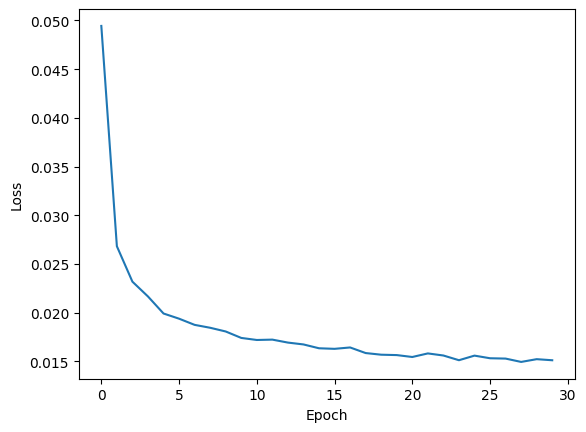

In [15]:
plt.clf()
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

100%|██████████| 1000/1000 [00:06<00:00, 153.43it/s]


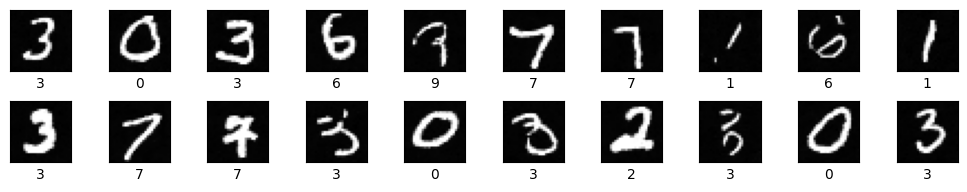

In [23]:
images, labels = diffuser.sample(model)
show_images(images, labels)

## Score-Based Diffusion models

In [34]:
class ScoreBasedDiffuser(Diffuser):
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device="cpu"):
        super().__init__(num_timesteps, beta_start, beta_end, device)

    def denoise(self, model, x, t, labels, gamma):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_idx = t - 1
        alpha = self.alphas[t_idx]
        alpha_bar = self.alpha_bars[t_idx]
        alpha_bar_prev = self.alpha_bars[t_idx - 1]

        N = alpha.size(0)
        alpha = alpha.view(N, 1, 1, 1)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)
        alpha_bar_prev = alpha_bar_prev.view(N, 1, 1, 1)

        model.eval()
        with torch.no_grad():
            eps_cond = model(x, t, labels) # <- adding labels tensor
            eps_uncond = model(x, t)
            eps = eps_uncond + gamma * (eps_cond - eps_uncond)
        model.train()

        noise = torch.randn_like(x, device=self.device)
        noise[t == 1] = 0

        mu = (x - ((1 - alpha) / torch.sqrt(1 - alpha_bar)) * eps) / torch.sqrt(alpha)
        std = torch.sqrt((1 - alpha) * (1 - alpha_bar_prev) / (1 - alpha_bar))
        return mu + std * noise
    
    def sample(self, model, x_shape=(20, 1, 28, 28), labels=None, gamma=3.0):
        batch_size = x_shape[0]
        x = torch.randn(x_shape, device=self.device)

        if labels is None: # <- adding labels tensor if label is None
            labels = torch.randint(0, 10, (len(x),), device=self.device)

        for i in tqdm(range(self.num_timesteps, 0, -1)):
            t = torch.tensor([i] * batch_size, device=self.device, dtype=torch.long)
            x = self.denoise(model, x, t, labels, gamma)
        
        images = [self.reverse_to_image(x[i]) for i in range(batch_size)]
        return images, labels


In [ ]:
img_size = 28
batch_size = 128
num_timesteps=1000
epochs=100
lr=1e-3
device = "cuda" if torch.cuda.is_available() else "cpu"

In [27]:
preprocess = transforms.ToTensor()
dataset = torchvision.datasets.MNIST(root="../data", train=True, transform=preprocess, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
diffuser = ScoreBasedDiffuser(num_timesteps=num_timesteps, device=device)
model = UNetCond(num_labels=10)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [28]:
losses = []
for epoch in range(epochs):
    loss_sum = 0.0
    cnt = 0

    for images, labels in tqdm(dataloader):
        optimizer.zero_grad()
        x = images.to(device)
        labels = labels.to(device)
        t = torch.randint(1, num_timesteps + 1, (len(x),), device=device)

        if np.random.random() < 0.1:
            labels=None

        x_noisy, noise = diffuser.add_noise(x, t)
        noise_pred = model(x_noisy, t, labels)
        loss = F.mse_loss(noise, noise_pred)

        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1
    loss_avg = loss_sum / cnt
    losses.append(loss_avg)
    print(f"Epoch: {epoch + 1}, Loss: {loss_avg}")


100%|██████████| 469/469 [00:28<00:00, 16.38it/s]


Epoch: 1, Loss: 0.04703213692680478


100%|██████████| 469/469 [00:28<00:00, 16.21it/s]


Epoch: 2, Loss: 0.026745232687925478


100%|██████████| 469/469 [00:28<00:00, 16.37it/s]


Epoch: 3, Loss: 0.023095083895570308


100%|██████████| 469/469 [00:28<00:00, 16.38it/s]


Epoch: 4, Loss: 0.021298149173686116


100%|██████████| 469/469 [00:28<00:00, 16.31it/s]


Epoch: 5, Loss: 0.020051447398611096


100%|██████████| 469/469 [00:28<00:00, 16.24it/s]


Epoch: 6, Loss: 0.019308715931642285


100%|██████████| 469/469 [00:28<00:00, 16.39it/s]


Epoch: 7, Loss: 0.01878183460168874


100%|██████████| 469/469 [00:28<00:00, 16.30it/s]


Epoch: 8, Loss: 0.018136901830607004


100%|██████████| 469/469 [00:28<00:00, 16.34it/s]


Epoch: 9, Loss: 0.01835378169266781


100%|██████████| 469/469 [00:28<00:00, 16.34it/s]


Epoch: 10, Loss: 0.017549359807565904


100%|██████████| 469/469 [00:28<00:00, 16.34it/s]


Epoch: 11, Loss: 0.017178165084962397


100%|██████████| 469/469 [00:28<00:00, 16.38it/s]


Epoch: 12, Loss: 0.01718291052297425


100%|██████████| 469/469 [00:28<00:00, 16.30it/s]


Epoch: 13, Loss: 0.017070352620105627


100%|██████████| 469/469 [00:28<00:00, 16.34it/s]


Epoch: 14, Loss: 0.016653119375917323


100%|██████████| 469/469 [00:28<00:00, 16.36it/s]


Epoch: 15, Loss: 0.01643858553726536


100%|██████████| 469/469 [00:28<00:00, 16.32it/s]


Epoch: 16, Loss: 0.016470151506602637


100%|██████████| 469/469 [00:28<00:00, 16.34it/s]


Epoch: 17, Loss: 0.016379623435564768


100%|██████████| 469/469 [00:28<00:00, 16.27it/s]


Epoch: 18, Loss: 0.016502435315154128


100%|██████████| 469/469 [00:28<00:00, 16.34it/s]


Epoch: 19, Loss: 0.01582940940909993


100%|██████████| 469/469 [00:28<00:00, 16.25it/s]


Epoch: 20, Loss: 0.01585994635635157


100%|██████████| 469/469 [00:28<00:00, 16.32it/s]


Epoch: 21, Loss: 0.01598287440899974


100%|██████████| 469/469 [00:28<00:00, 16.36it/s]


Epoch: 22, Loss: 0.01586115532028459


100%|██████████| 469/469 [00:28<00:00, 16.27it/s]


Epoch: 23, Loss: 0.01562881772952484


100%|██████████| 469/469 [00:28<00:00, 16.37it/s]


Epoch: 24, Loss: 0.015374781544020435


100%|██████████| 469/469 [00:28<00:00, 16.32it/s]


Epoch: 25, Loss: 0.015419566243299161


100%|██████████| 469/469 [00:28<00:00, 16.26it/s]


Epoch: 26, Loss: 0.0156437652622427


100%|██████████| 469/469 [00:28<00:00, 16.27it/s]


Epoch: 27, Loss: 0.015351976414939869


100%|██████████| 469/469 [00:28<00:00, 16.29it/s]


Epoch: 28, Loss: 0.015230140658711065


100%|██████████| 469/469 [00:28<00:00, 16.34it/s]


Epoch: 29, Loss: 0.015002989738401192


100%|██████████| 469/469 [00:28<00:00, 16.33it/s]


Epoch: 30, Loss: 0.015008557355527813


100%|██████████| 469/469 [00:28<00:00, 16.38it/s]


Epoch: 31, Loss: 0.015006957083209746


 25%|██▍       | 115/469 [00:07<00:21, 16.19it/s]


KeyboardInterrupt: 

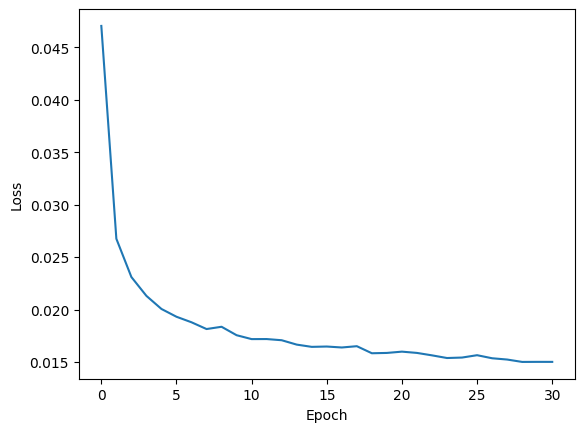

In [29]:
plt.clf()
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### Gamma=1.0

100%|██████████| 1000/1000 [00:11<00:00, 88.91it/s]


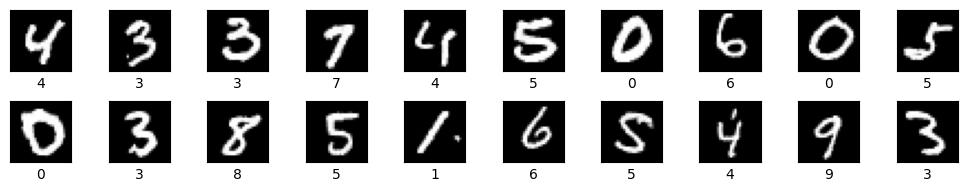

In [43]:
images, labels = diffuser.sample(model, gamma=1.0)
show_images(images, labels)

### Gamma=2.0

100%|██████████| 1000/1000 [00:11<00:00, 88.85it/s]


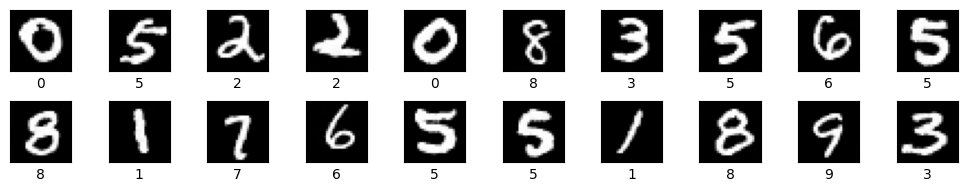

In [40]:
images, labels = diffuser.sample(model, gamma=2.0)
show_images(images, labels)

- 이미지가 좀더 선명해졌다. 신기하다!

### Gamma=3.0

100%|██████████| 1000/1000 [00:11<00:00, 88.59it/s]


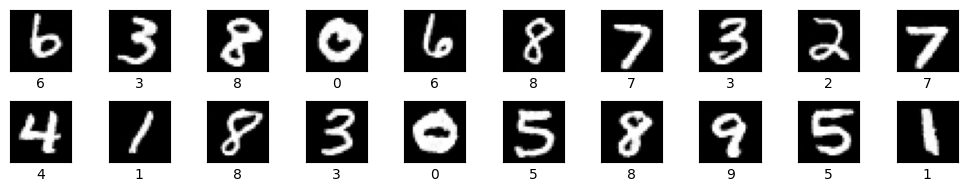

In [41]:
images, labels = diffuser.sample(model, gamma=3.0)
show_images(images, labels)